In [74]:
import lib.simulation

In [75]:
from lib.statistics import Statistics, stats_to_numpy, load_logs
import os
%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [76]:
target = 'coh'
xlabel = "Weight of Cohesion (%)"

# target = 'alignment'
# xlabel = "Weight of Alignment (%) (Cohesion is OFF!)"

In [77]:
paths = ["logs/" + path for path in os.listdir("logs") if path[:len(target)] == target]

data = {} # data = {cohesion : {"boid_count":array([simulations x measurements]), ""}}

for path in sorted(paths):
    ratio = float(path[5+len(target):])
    
    pars, stats = load_logs(path)
    s, bc, sc, ss = stats_to_numpy(stats, pars)

    ratio_dic = {"boid_count" : bc[:, :-1], "school_count" : sc[:, :-1], "school_size" : ss[:, :-1]}

    data[ratio] = ratio_dic

In [78]:
cutoff = 3000

surviving = []
surviving_std = []

for i, (cohesion, cohesion_data) in enumerate(data.items()):
    means = np.mean(cohesion_data["boid_count"], axis=0)
    stds = np.std(cohesion_data["boid_count"], axis=0)

    surviving.append(means[cutoff // pars.resolution])
    surviving_std.append(stds[cutoff // pars.resolution])

In [79]:
cohesion

1.0

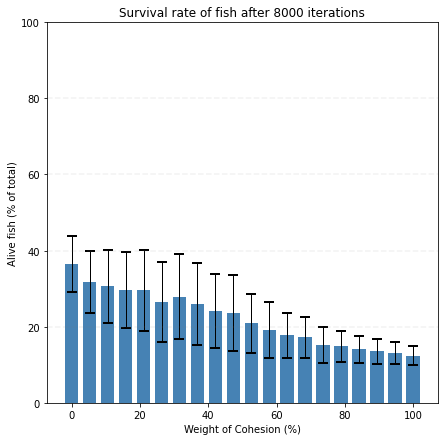

In [80]:
fig, ax = plt.subplots(figsize=(7,7))
ax.set_title("Survival rate of fish after " + str(cutoff) + " iterations")

# ax.fill_between(ratios, np.array(surviving)-np.array(surviving_std), np.array(surviving)+np.array(surviving_std), alpha=0.1)
# ax.plot(ratios, surviving)


ax.bar(np.array(list(data.keys())) * 100, np.array(surviving)/250*100, yerr=np.array(surviving_std)/250*100, width=4, color="steelblue",
error_kw=dict(ecolor='black', lw=1, capsize=5, capthick=2))

ax.set_axisbelow(True)
for i in [20, 40, 60, 80, 100]:
    ax.axhline(i, color='gray', linestyle='dashed', alpha=0.1)
# ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_ylabel("Alive fish (% of total)")

ax.set_xlabel(xlabel)

# The fish freely move based on two factors: cohesion and alignment. The X axis represents how much the cohesion weighs in this decision

ax.set_ylim(0,100)
plt.show()

# TODO:
# Y as moet percentage worden _/
# Iteratie count leuk getal kiezen _/
# Kleurtje kiezen _/
# X as label kiezen

In [81]:
color_map = plt.get_cmap("copper").reversed()

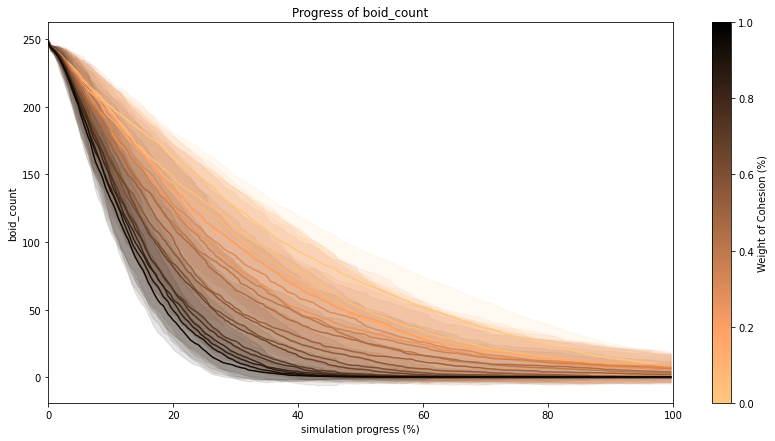

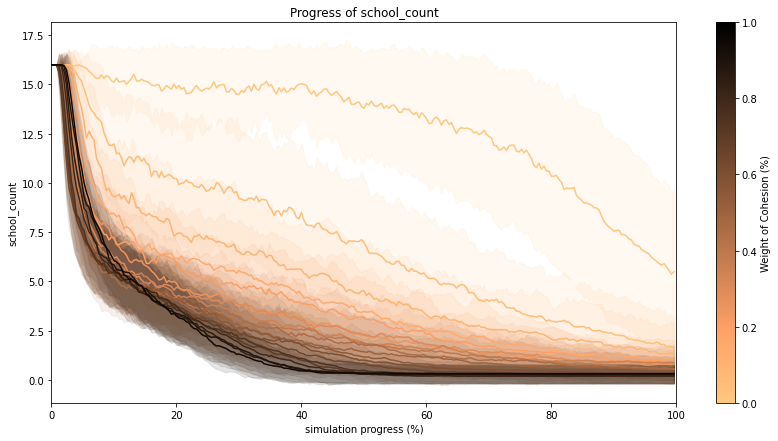

In [82]:


labels = ["boid_count", "school_count"]

selected_ratios = None

for label in labels:
    fig, ax = plt.subplots(figsize=(14,7))
    # print(sc)
    # print(sc.shape)


    sm = plt.cm.ScalarMappable(cmap=color_map)#, norm=plt.normalize(min=0, max=1))
    fig.colorbar(sm, label=xlabel)
    for i, (cohesion, cohesion_data) in enumerate(data.items()):
            if not selected_ratios:
                pass
            elif i not in selected_ratios:
                continue
                
            mean_school_progression = np.mean(cohesion_data[label], axis=0)

            xs = np.arange(0,len(mean_school_progression))/len(mean_school_progression)*100
            ax.plot(xs,
                    mean_school_progression, color = color_map(i/len(paths)), label=path)

            std_school_progression = np.std(cohesion_data[label], axis=0)
            ax.fill_between(xs,
                            mean_school_progression-std_school_progression, 
                            mean_school_progression+std_school_progression, 
                            alpha=0.1, color = color_map(i/len(paths)))


    ax.set_title("Progress of " + label)

    ax.set_ylabel(label)

    ax.set_xlabel("simulation progress (%)")

    ax.set_xlim(0,100)
    plt.show()

    # TODO:
    # Y as percentage maken bij boid count
    # Een paar cohesion % kiezen om te plotten

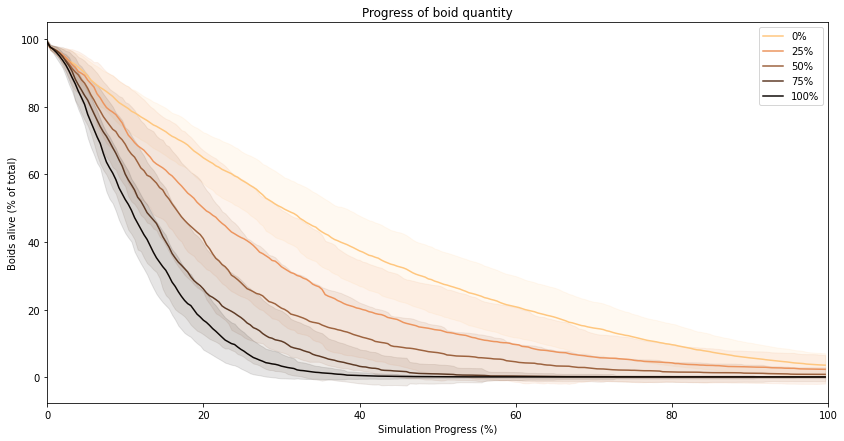

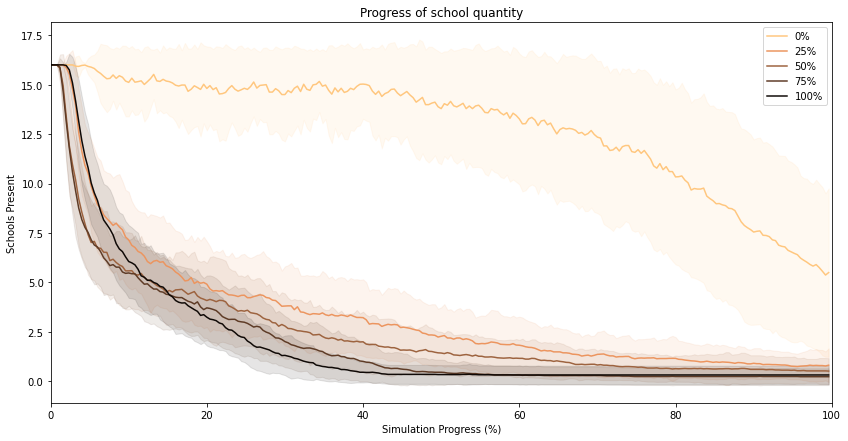

In [83]:
labels = ["boid_count", "school_count"]

selected_ratios = [0, 5, 10, 14, 19]
cheated_labels = ["0%", "25%", "50%", "75%", "100%"]

def get_label(perc):
    if perc < 0.2:
        return "0%"
    if perc < 0.4:
        return "25%"
    if perc < 0.6:
        return "50%"
    if perc < 0.8:
        return "75%"
    return "100%"

def lelijke_fix(label):
    if label == "boid_count":
        return "Boids alive (% of total)"
    return "Schools Present"

def lelijke_fix2(label):
    if label == "boid_count":
        return "boid quantity"
    return "school quantity"

for label in labels:
    fig, ax = plt.subplots(figsize=(14,7))
    # print(sc)
    # print(sc.shape)


    sm = plt.cm.ScalarMappable(cmap=color_map)#, norm=plt.normalize(min=0, max=1))
    hardcode = 0
    for i, (cohesion, cohesion_data) in enumerate(data.items()):
            if not selected_ratios:
                pass
            elif i not in selected_ratios:
                continue

            hardcode += 1
                
            mean_school_progression = np.mean(cohesion_data[label], axis=0)

            xs = np.arange(0,len(mean_school_progression))/len(mean_school_progression)*100
            if label=="boid_count":
                ax.plot(xs,
                        np.array(mean_school_progression)/250*100, color = color_map(i/len(paths)), label=get_label(cohesion))
                std_school_progression = np.std(cohesion_data[label], axis=0)
                ax.fill_between(xs,
                                np.array(mean_school_progression-std_school_progression)/250*100, 
                                np.array(mean_school_progression+std_school_progression)/250*100, 
                                alpha=0.1, color = color_map(i/len(paths)))
            else:
                ax.plot(xs,
                        mean_school_progression, color = color_map(i/len(paths)), label=get_label(cohesion))
                std_school_progression = np.std(cohesion_data[label], axis=0)
                ax.fill_between(xs,
                                mean_school_progression-std_school_progression, 
                                mean_school_progression+std_school_progression, 
                                alpha=0.1, color = color_map(i/len(paths)))



    if not selected_ratios:
        fig.colorbar(sm, label="cohesion influence over allignment influence")
    else:
        plt.legend()

    ax.set_title("Progress of " + lelijke_fix2(label))

    ax.set_ylabel(lelijke_fix(label))

    ax.set_xlabel("Simulation Progress (%)")

    ax.set_xlim(0,100)
    plt.show()

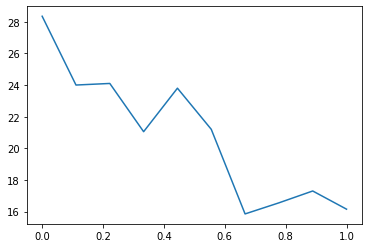

In [33]:
avg_it = []
max_fish = 250
percentage_still_alive = 0.1
for i, (cohesion, cohesion_data) in enumerate(data.items()):
    fiddy_percent = max_fish * percentage_still_alive

    still_alive = cohesion_data["boid_count"] > fiddy_percent
    # cohesion_data["school_count"][np.where(still_alive)] = 
    avg_it.append(np.mean(np.sum(still_alive, axis=1)))

plt.plot(data.keys(), avg_it)
plt.show()